In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
## Reading in the data:


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld2 setup
run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
print(os)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
<xarray.Dataset>
Dimensions:        (Interface: 16, Layer: 15, Time: 7082)
Coordinates:
  * Layer          (Layer) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * Interface      (Interface) float64 1.022e+03 1.023e+03 ... 1.028e+03
  * Time           (Time) float64 0.0 5.0 10.0 ... 3.249e+04 3.25e+04 3.25e+04
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
Attributes:
    filename:  ./ocean.stats.nc


In [4]:
print(av.Rd1)
#dxCu and dxCv are the spacings in meters... I've just been using coordinates as degrees.
#dx varies with latitude and dy stays constant with latitude
#when interpolating onto a finer grid we want to keep dy the same, and make dx = dy everywhere.

<xarray.DataArray 'Rd1' (time: 100, yh: 2240, xh: 960)>
[215040000 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 -69.97 -69.91 -69.84 -69.78 ... 69.84 69.91 69.97
  * time     (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.049e+04 3.05e+04
  * xh       (xh) float64 0.03125 0.09375 0.1562 0.2188 ... 59.84 59.91 59.97
Attributes:
    long_name:      First baroclinic deformation radius
    units:          m
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT


In [5]:
lat=  np.array(av.yh)     #np.array(fs['geolon']); 
lon=  np.array(av.xh)     #fs['geolat']
area= np.array(fs['area_t'])

u= av.u[:,0,:,:]-(av.u[:,0,:,:].mean('time')) #We're removing the temporally-averaged mean flow.
v= av.v[:,0,:,:]-(av.v[:,0,:,:].mean('time'))
PV=av.PV[-1,0,:,:]-(av.PV[:,0,:,:].mean('time'))
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')
u = grid.interp(u,axis='X')
v = grid.interp(v,axis='Y')
PV = grid.interp(PV,axis='X'); PV=grid.interp(PV,axis='Y')
print(u.shape,v.shape)
#dx = xr.DataArray(data=fs.dxCu.isel(xq=slice(0,len(lon))),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

(100, 2240, 960) (100, 2240, 960)


In [6]:
print('min dx:',2*np.pi*6378000*np.cos(70*np.pi/180)/360/16)
print('max dx:',2*np.pi*6378000/360/16)

min dx: 2379.543149457715
max dx: 6957.318730762397


In [7]:
Ld = av.Rd1[:].mean('time')
Ld.shape
dx.shape

(2240, 960)

In [8]:
plt.rcParams.update({'font.size': 18})

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


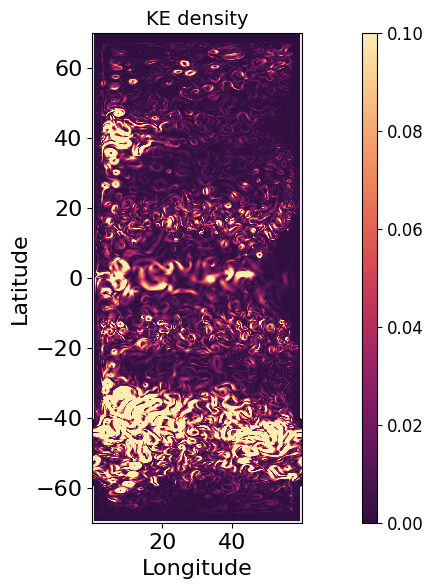

In [9]:
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('KE density',fontsize=14)

KE=(u**2+v**2)*0.5
plotted =ax1.pcolor(lon,lat,KE[-1,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=1e-1)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

## We will now interpolate onto an X,Y grid (2D, irregular) and then onto a uniformly spaced X,Y grid with a resolution of 5km. In the 1/16 degree case the smallest grid spacing was 7km.

In [10]:
OGx=dx.cumsum(axis=1)-dx[:,0] #subtract first dx so that we start at x=0m.
OGy=dy.cumsum(axis=0)-dy[0,:]

OGx=(OGx-OGx[:,479]) #Center the grid along the center longitude.
OGy=(OGy-OGy[1119,:]) #Center the grid along the center latitude
dxnew = 5000; #meters; x coordinates range from -3340km to 3332km
dynew = 5000; #meters; y coordinates range from -7792 kmto 7785km

x5km = np.arange(-3330e3,3334e3,dxnew)
y5km = np.arange(-7785e3,7792e3,dynew)

# #Using example here: http://christopherbull.com.au/python/scipy-interpolate-griddata/
# #old grid dim
xi=np.array(OGx)
yi=np.array(OGy)


# #create mesh
Xnew, Ynew = np.meshgrid(x5km,y5km)



In [13]:

u_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(u[-1,:,:]).flatten() , (Xnew,Ynew),method='linear')
v_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(v[-1,:,:]).flatten() , (Xnew,Ynew),method='linear')
KE_regular = 0.5*(u_regular**2+v_regular**2)
Ld_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(Ld).flatten() , (Xnew,Ynew),method='linear')

print(u_regular.shape)


u_regular = xr.DataArray(u_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
v_regular = xr.DataArray(v_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
KE_regular= xr.DataArray(KE_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
Ld_regular=xr.DataArray(Ld_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])

(3116, 1333)


In [14]:
u_regular.shape

(3116, 1333)

### At one time step, computing the spectrum:

In [15]:
x1= -1500e3; x2=-x1;
y1= 1000e3; y2= y1+100e3; #defining slices in latitude that will be 100km or 20 grid points tall


u_small=u_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))
v_small=v_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))
Ld_small=Ld_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))
KE_small=KE_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))
# u_small.shape

with ProgressBar():
    uiso2 = xrft.power_spectrum(u_small,dim=['x5km'], detrend='linear').compute() #, window='hamming', detrend='linear'
    viso2 = xrft.power_spectrum(v_small,dim=['x5km'], detrend='linear').compute()

    
    # with ProgressBar():
#     uhat2 = xrft.power_spectrum(u_small,dim=['x5km','y5km'],detrend='linear',scaling='spectrum').compute()
#     vhat2 = xrft.power_spectrum(v_small,dim=['x5km','y5km'],detrend='linear',scaling='spectrum').compute()
# ekehat = .5*(uhat2 + vhat2)
# ekehat

ekeiso = .5*(uiso2 + viso2)
plot_x= (ekeiso.freq_x5km*1e3*2*np.pi)
#plot_y= (ekeiso[-1,:]) #finding mean
plot_y= (ekeiso.mean('y5km')) #finding mean
Energetic_wavenumber=plot_y[301:].idxmax(dim='freq_x5km')*1000*2*np.pi

LD_wavenumber=np.nanmean(1/(Ld_small/1000))

print('energy scale=',1/Energetic_wavenumber)
print('deformation radius=',1/LD_wavenumber)

energy scale= <xarray.DataArray 'freq_x5km' ()>
array(53.14006711)
deformation radius= 142.69029536026247


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


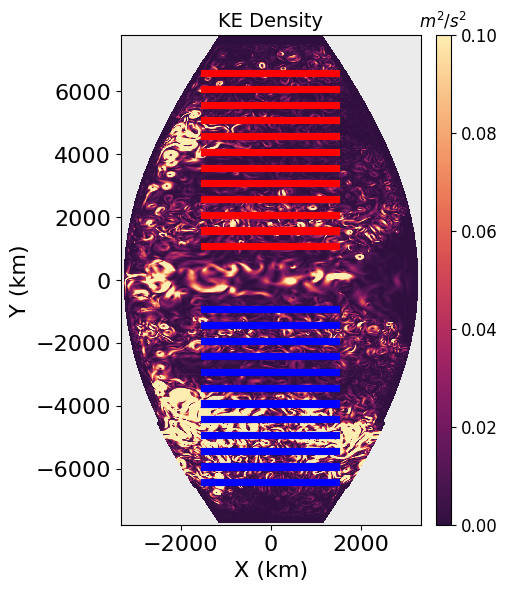

In [16]:
from matplotlib.patches import Rectangle
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('X (km)',fontsize=16)
ax1.set_ylabel('Y (km)',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('KE Density',fontsize=14)

plotted =ax1.pcolor(Xnew/1000,Ynew/1000,KE_regular,cmap=cmocean.cm.matter_r,vmin=0,vmax=.1)
#plotted =ax1.pcolor(Xnew/1000,Ynew/1000,u_regular,cmap=cmocean.cm.curl,vmin=-10,vmax=10)
#ax1.add_patch(Rectangle((-1500,3000),3000,1,linewidth=3,edgecolor='r',facecolor='none'))
for i in [1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500]:
    ax1.add_patch(Rectangle((x1/1000,i),abs(x2-x1)/1000,100,linewidth=3,edgecolor='r',facecolor='none'))
    ax1.add_patch(Rectangle((x1/1000,-i),abs(x2-x1)/1000,100,linewidth=3,edgecolor='b',facecolor='none'))



#ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$m^2/s^2$',fontsize=12)



#
plt.show()

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

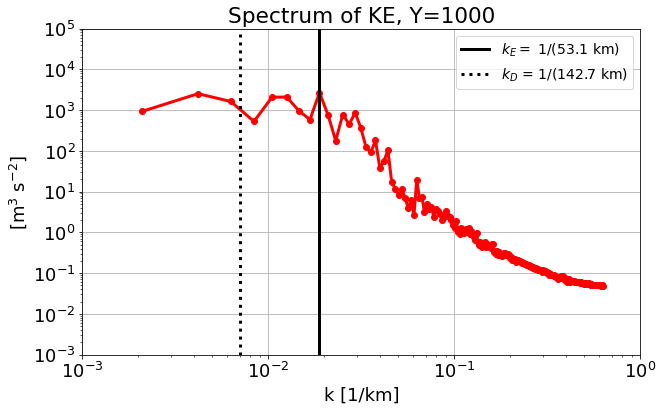

In [17]:
fig, ax = plt.subplots(figsize=(10,6))



plt.plot(plot_x[301:],plot_y[301:],'-or',linewidth=3)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
l1=plt.plot([Energetic_wavenumber,Energetic_wavenumber], [1e-3,1e5],color='k',linewidth=3,label='$k_E=$ 1/(%.1f km)'%(1/Energetic_wavenumber))
l2=plt.plot([LD_wavenumber,LD_wavenumber], [1e-3,1e5],':k',linewidth=3,label='$k_D$ = 1/(%.1f km)'%(1/LD_wavenumber))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=1000')
plt.ylim([1e-3, 1e5])
plt.xlim([1e-3, 1e0])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

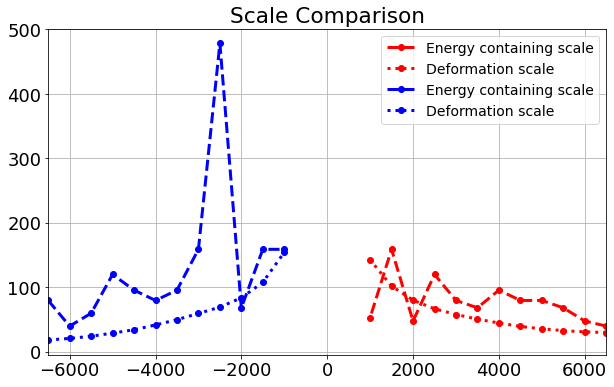

In [138]:
LE_S= [79.7, 39.9, 59.8, 120,95.7, 79.7, 95.7, 159, 478.3, 68.3, 159, 159]
LD_S= [18.4, 20.8, 24.2, 29, 34.3, 41.7, 49.9, 59.5, 69.4, 83.77, 107.8, 154.3]
Y_S = [-6500,-6000,-5500,-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000]

Y_N = [6500, 6000, 5500, 5000, 4500, 4000, 3500, 3000, 2500, 2000, 1500, 1000]
LE_N= [39.9, 47.8, 68.3, 79.7, 79.7, 95.7, 68.3, 79.7, 120,  47.8, 159,  53.1 ]
LD_N= [29.9, 31.0, 32.9, 35.7, 39.4, 44.7, 50.7, 57.9, 66.8, 80.1, 102, 142.7]

fig, ax = plt.subplots(figsize=(10,6))


plt.plot(Y_N,LE_N,'--or',linewidth=3,label='Energy containing scale')  
plt.plot(Y_N,LD_N,':or',linewidth=3,label='Deformation scale')  
plt.plot(Y_S,LE_S,'--ob',linewidth=3,label='Energy containing scale')  
plt.plot(Y_S,LD_S,':ob',linewidth=3,label='Deformation scale')  

plt.title('Scale Comparison')
#plt.ylim([1e-3, 1e5])
plt.xlim([-6500, 6500])
plt.grid()
#plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

### Computing the spectrum over many time steps:

In [156]:
x1= -1500e3; x2=-x1;
y1= 1000e3; y2= y1+100e3; #defining slices in latitude that will be 100km or 20 grid points tall



for i in range(0,1):
    u_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(u[i,:,:].fillna(0.)).flatten() , (Xnew,Ynew),method='linear')
    v_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(v[i,:,:].fillna(0.)).flatten() , (Xnew,Ynew),method='linear')
    Ld_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(Ld.fillna(0.)).flatten() , (Xnew,Ynew),method='linear')

    print(u_regular.shape)


    u_regular = xr.DataArray(u_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
    v_regular = xr.DataArray(v_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
    Ld_regular=xr.DataArray(Ld_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])


    u_small=u_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))
    v_small=v_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))
    Ld_small=Ld_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))
    KE_small=KE_regular.sel(x5km=slice(x1, x2),y5km=slice(y1, y2))


    uiso2 = xrft.power_spectrum(u_small,dim=['x5km'], detrend='linear').compute() #, window='hamming', detrend='linear'
    viso2 = xrft.power_spectrum(v_small,dim=['x5km'], detrend='linear').compute()
    ekeiso = .5*(uiso2 + viso2)
    
    plot_x= (ekeiso.freq_x5km*1e3*2*np.pi)
    plot_y= (ekeiso.mean('y5km')) #finding mean
    Energetic_wavenumber=plot_y[301:].idxmax(dim='freq_x5km')*1000*2*np.pi

    LD_wavenumber=np.nanmean(1/(Ld_small/1000))

    print('energy scale=',1/Energetic_wavenumber)
    print('deformation radius=',1/LD_wavenumber)



(3116, 1333)
